In [1]:
import sys
sys.path.append('../../..')
import warnings
warnings.filterwarnings('ignore')

In [2]:
import os
import numpy as np
import xarray as xr
import random as rd
import platform
import adamod
import torch
import torch.nn.functional as F


from torch.utils.data import DataLoader
from collections import OrderedDict
from torch.nn.parameter import Parameter
import matplotlib.pyplot as plt
from MogrifierLSTM import MogrifierLSTMCell
from utils.dataset import NCDFDatasets
from utils.trainer import Tester
from utils.trainer import Trainer
from datetime import datetime
from evonorm import EvoNorm3D

In [3]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
if (torch.cuda.is_available()):
    torch.cuda.empty_cache()
device

device(type='cuda', index=0)

In [4]:
batch_size = 25
validation_split = 0.2
test_split = 0.2
dropout_rate = 0.2
hidden_size = 32*32
mogrify_rounds = 5
param = {'encoder_layer_size': 3, 'decoder_layer_size': 3, 'kernel_size': 5, 'filter_size': 32}

grid_mask_param = {'ratio':0.8, 'max_prob': 0.3, 'd1':3, 'd2': 12, 'max_epochs': 10}

In [5]:
import xarray as xr
data_path = '../../../data/dataset-ucar-1979-2015-seq5-ystep5.nc'
dataset = xr.open_dataset(data_path)
print(dataset)

<xarray.Dataset>
Dimensions:  (channel: 1, lat: 32, lon: 32, sample: 54047, time: 5)
Coordinates:
  * lat      (lat) int32 -54 -52 -50 -48 -46 -44 -42 -40 ... -6 -4 -2 0 2 4 6 8
  * lon      (lon) int32 278 280 282 284 286 288 290 ... 330 332 334 336 338 340
Dimensions without coordinates: channel, sample, time
Data variables:
    x        (sample, time, lat, lon, channel) float32 ...
    y        (sample, time, lat, lon, channel) float32 ...
Attributes:
    description:  The variables have air temperature values and are separable...


In [6]:
#In these experiments y has dimensions [batch, channel, lat, lon] as opposed to [batch, channel, time, lat, lon] to
#avoid dimension conflict with conv kernels
data = NCDFDatasets(dataset, val_split = 0.2, test_split = 0.2, cut_y=True)
train_data = data.get_train()
val_data = data.get_val()
test_data = data.get_test()

In [7]:
print("-----Train-----")
print("X : ", train_data.x.shape)
print("Y : ", train_data.y.shape)
print("-----Val-----")
print("X : ", val_data.x.shape)
print("Y : ", val_data.y.shape)
print("-----Test-----")
print("X : ", test_data.x.shape)
print("Y : ", test_data.y.shape)

-----Train-----
X :  torch.Size([32429, 1, 5, 32, 32])
Y :  torch.Size([32429, 1, 32, 32])
-----Val-----
X :  torch.Size([10809, 1, 5, 32, 32])
Y :  torch.Size([10809, 1, 32, 32])
-----Test-----
X :  torch.Size([10809, 1, 5, 32, 32])
Y :  torch.Size([10809, 1, 32, 32])


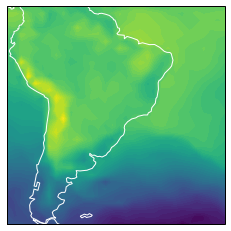

In [8]:
import cartopy.crs as ccrs
import matplotlib.pyplot as plt
import cartopy
#sample, ch, time, lat, lon
sst = train_data.y[0, 0, :, :]
lats = dataset.variables['lat'][:]
lons = dataset.variables['lon'][:]

ax = plt.axes(projection=ccrs.PlateCarree())

plt.contourf(lons, lats, sst, 60,
             transform=ccrs.PlateCarree())
ax.coastlines(color='white')

plt.show()

In [9]:
seed = 1000
np.random.seed(seed)
rd.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.backends.cudnn.deterministic=True

def init_seed(seed):
    np.random.seed(seed)
    
init_seed = init_seed(seed)

In [10]:
params = {'batch_size': batch_size,
          'num_workers': 4,
          'worker_init_fn': init_seed}

train_loader = DataLoader(dataset=train_data, shuffle=True, **params)
val_loader = DataLoader(dataset=val_data, shuffle=False, **params)
test_loader = DataLoader(dataset=test_data, shuffle=False, **params)

In [11]:
class Mish(torch.nn.Module):
    def __init__(self):
        super().__init__()

    def forward(self, x):
        #inlining this saves 1 second per epoch (V100 GPU) vs having a temp x and then returning x(!)
        return x *( torch.tanh(F.softplus(x)))

In [12]:
class CustomConv2d(torch.nn.Conv2d):
    def __init__(self, in_channels, out_channels, kernel_size, stride=1,
                 padding=0, dilation=1,
                 bias=False, padding_mode='zeros', weight=None):
        super().__init__(in_channels, out_channels, kernel_size, stride=stride,
                 padding=padding, dilation=dilation,
                 bias=bias, padding_mode=padding_mode)
        
        self.padding = [kernel_size // 2, kernel_size // 2]
        
    def forward(self,input, weight=None):
        if (weight is not None):
            return F.conv2d(input, weight.permute(1,0,2,3), self.bias, self.stride,
                        self.padding, self.dilation)
        else:
            return F.conv2d(input, self.weight, self.bias, self.stride,
                        self.padding, self.dilation)

In [13]:
class EncoderCNN(torch.nn.Module):
    def __init__(self, layer_size, kernel_size, initial_out_channels, initial_in_channels, device):
        super(EncoderCNN, self).__init__()
        self.device = device
        self.layer_size = layer_size
        self.conv_layers = torch.nn.ModuleList()
        self.bn_layers = torch.nn.ModuleList()
        self.decode_bn_layers = torch.nn.ModuleList()
        
        in_channels = initial_in_channels
        out_channels = initial_out_channels
        for i in range(self.layer_size):
            self.conv_layers.append(CustomConv2d(in_channels = in_channels, out_channels = out_channels,
                                                kernel_size = kernel_size))
            self.bn_layers.append(EvoNorm3D(out_channels, version = 'B0_3D'))
            self.decode_bn_layers.append(EvoNorm3D(out_channels, version = 'B0_3D'))
            in_channels = out_channels
            
        self.conv_reduce = CustomConv2d(in_channels = in_channels, out_channels = 1,
                                                kernel_size = 1)
            
            
    def forward(self, x, dimens, decode=False):
        batch, channel, time, lat, lon = dimens
        if (decode):
            x = self.conv_reduce(x, self.conv_reduce.weight)
            for i in range(self.layer_size-1, -1, -1):
                x = torch.unsqueeze(x, 2)
                x = self.decode_bn_layers[i](x)
                x = torch.squeeze(x, 2)
                x = self.conv_layers[i](x, self.conv_layers[i].weight)
        else:
            for i in range(self.layer_size):
                x = self.conv_layers[i](x)
                ch = x.size()[1]
                x = x.view(batch, ch, time, lat, lon)
                x = self.bn_layers[i](x)
                x = x.view(batch*time, ch, lat, lon)
            x = self.conv_reduce(x)
        return x

In [14]:
class STModel(torch.nn.Module):
    def __init__(self, encoder_layer_size, kernel_size, out_channels, in_channels, input_width, input_height, hidden_size
                 , device):
        super(STModel, self).__init__()
        self.device = device
        self.encoder = EncoderCNN(layer_size = encoder_layer_size, kernel_size = kernel_size,
                                initial_out_channels = out_channels,
                                initial_in_channels = in_channels, device=device)
        self.recurrent_encoder = torch.nn.LSTMCell(input_width*input_height, hidden_size);
        #self.recurrent_decoder = torch.nn.LSTMCell(input_width*input_height, hidden_size);
       
        
    def forward(self, x, states):
        batch, channel, time, lat, lon = x.size()
        x = x.view(batch*time, channel, lat, lon)
        x = self.encoder(x, [batch, channel, time, lat, lon])
        
        x = x.view(batch, time, -1)
        h = states[0]
        c = states[1]
        for i in range(time):
            h,c = self.recurrent_encoder(x[:,i,:],(h,c))
            
        x = h.contiguous().view(batch, channel, lat, lon)
        x = self.encoder(x, [batch, channel, time, lat, lon], decode=True)
        return x
        

In [15]:
class RMSELoss(torch.nn.Module):
    def __init__(self, eps=1e-6):
        super().__init__()
        self.mse = torch.nn.MSELoss()
        self.eps = eps
        
    def forward(self,yhat,y):
        loss = torch.sqrt(self.mse(yhat,y) + self.eps)
        return loss

In [16]:
model = STModel(encoder_layer_size = param['encoder_layer_size'], kernel_size = param['kernel_size'], out_channels = param['filter_size'],
                in_channels = train_data.x.shape[1], input_width = train_data.x.shape[3], 
                input_height = train_data.x.shape[4], hidden_size = hidden_size, device=device).to(device)
criterion = torch.nn.L1Loss()
#optimizer_params = {'lr': 0.001}
#optimizer = torch.optim.Adam(net.parameters(), **optimizer_params)
opt_params = {'lr': 0.001, 
              'beta3': 0.999}
optimizer = adamod.AdaMod(model.parameters(), **opt_params)
model

STModel(
  (encoder): EncoderCNN(
    (conv_layers): ModuleList(
      (0): CustomConv2d(1, 32, kernel_size=(5, 5), stride=(1, 1), padding=[2, 2], bias=False)
      (1): CustomConv2d(32, 32, kernel_size=(5, 5), stride=(1, 1), padding=[2, 2], bias=False)
      (2): CustomConv2d(32, 32, kernel_size=(5, 5), stride=(1, 1), padding=[2, 2], bias=False)
    )
    (bn_layers): ModuleList(
      (0): EvoNorm3D()
      (1): EvoNorm3D()
      (2): EvoNorm3D()
    )
    (decode_bn_layers): ModuleList(
      (0): EvoNorm3D()
      (1): EvoNorm3D()
      (2): EvoNorm3D()
    )
    (conv_reduce): CustomConv2d(32, 1, kernel_size=(1, 1), stride=(1, 1), padding=[0, 0], bias=False)
  )
  (recurrent_encoder): LSTMCell(1024, 1024)
)

In [17]:
model_path = os.path.join('../../../models/CFSR/1_step/STTSModel_3D_EvoNormB0_3D_GridMask_MAE' + '_' + datetime.now().strftime('m%md%d-h%Hm%Ms%S') + '.pth.tar')
trainer = Trainer(model, train_loader, val_loader, criterion, optimizer, 100, device, model_path, recurrent_model=True, cut_output=True, patience=10,grid_mask=grid_mask_param)


In [18]:
train_losses, val_losses = trainer.train_evaluate()

0.3
Train - Epoch 0, Epoch Loss: 2.158926
Val Avg. Loss: 1.241385
=> Saving a new best
Train - Epoch 1, Epoch Loss: 1.145313
Val Avg. Loss: 1.357454
Train - Epoch 2, Epoch Loss: 0.998372
Val Avg. Loss: 0.975970
=> Saving a new best
Train - Epoch 3, Epoch Loss: 0.932433
Val Avg. Loss: 0.994585
Train - Epoch 4, Epoch Loss: 0.895984
Val Avg. Loss: 0.952786
=> Saving a new best
Train - Epoch 5, Epoch Loss: 0.861566
Val Avg. Loss: 0.878865
=> Saving a new best
Train - Epoch 6, Epoch Loss: 0.842293
Val Avg. Loss: 1.080353
Train - Epoch 7, Epoch Loss: 0.826585
Val Avg. Loss: 1.022167
Train - Epoch 8, Epoch Loss: 0.805851
Val Avg. Loss: 0.844814
=> Saving a new best
Train - Epoch 9, Epoch Loss: 0.789971
Val Avg. Loss: 1.430081
Train - Epoch 10, Epoch Loss: 0.779674
Val Avg. Loss: 0.959074
Train - Epoch 11, Epoch Loss: 0.770218
Val Avg. Loss: 0.915336
Train - Epoch 12, Epoch Loss: 0.759102
Val Avg. Loss: 1.095627
Train - Epoch 13, Epoch Loss: 0.751114
Val Avg. Loss: 0.899046
Train - Epoch 14, E

KeyboardInterrupt: 

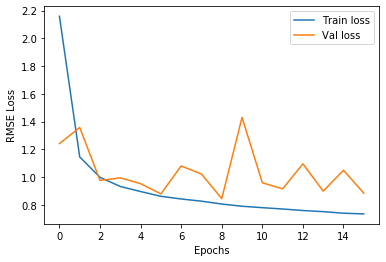

In [19]:
epochs = np.arange(1,len(val_losses))
plt.plot(train_losses)
plt.plot(val_losses)
plt.legend(['Train loss', 'Val loss'], loc='upper right')
plt.xlabel("Epochs")
plt.ylabel("RMSE Loss")
plt.show()

In [19]:
def init_hidden(batch_size, hidden_size):
    h = torch.zeros(batch_size,hidden_size, device=device)
    return (h,h)

model, optimizer, epoch, loss = trainer.load_model()
batch_test_loss = 0.0
model.eval()
with torch.no_grad():
    for i, (x, y) in enumerate(test_loader):
        x,y = x.to(device), y.to(device)
        states = init_hidden(x.size()[0], x.size()[3]*x.size()[4])
        output = model(x, states)
        loss = criterion(output, y)
        batch_test_loss += loss.detach().item()
test_loss = batch_test_loss/len(test_loader)
loss_type = type(criterion).__name__
print(f'STConvS2S {loss_type}: {test_loss:.4f}')

STConvS2S L1Loss: 0.7262


In [20]:
def init_hidden(batch_size, hidden_size):
    h = torch.zeros(batch_size,hidden_size, device=device)
    return (h,h)

trainer.path = '../../../models/CFSR/1_step/STTSModel_3D_EvoNormB0_3D_GridMask_MAE_m06d05-h13m34s56.pth.tar'
model, optimizer, epoch, loss = trainer.load_model()
batch_test_loss = 0.0
model.eval()
previous_three_steps = []

with torch.no_grad():
    for i, (x, y) in enumerate(test_loader):
        for j in range(2,5):
            previous_three_steps.append(x[19,0,j,:,:])
        x,y = x.to(device), y.to(device)
        ground_truth = y[19,0,:,:]
        states = init_hidden(x.size()[0], x.size()[3]*x.size()[4])
        output = model(x, states)
        prediction = output[19,0,:,:]
        print(criterion(prediction, ground_truth))
        break

tensor(0.9366, device='cuda:0')


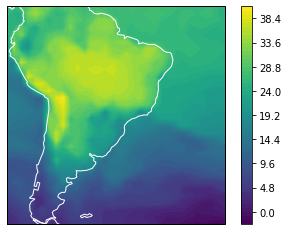

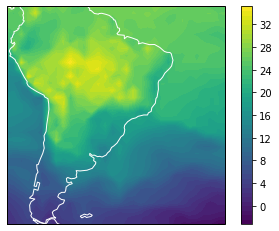

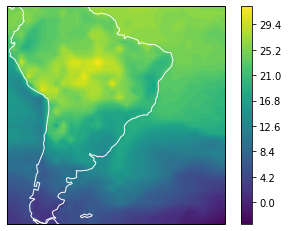

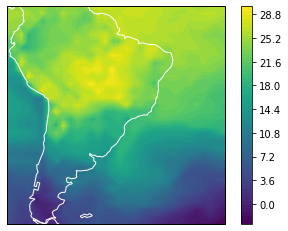

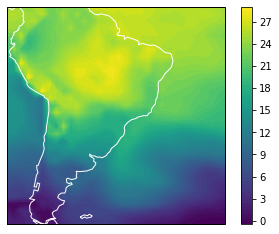

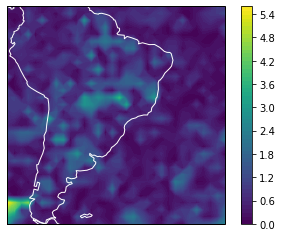

In [21]:
sst = previous_three_steps[0]
lats = dataset.variables['lat'][:]
lons = dataset.variables['lon'][:]

ax = plt.axes(projection=ccrs.PlateCarree())

plt.contourf(lons, lats, sst, 60,
             transform=ccrs.PlateCarree())
ax.coastlines(color='white')

plt.plot(color='white')
plt.colorbar()
plt.show()

sst = previous_three_steps[1]
ax = plt.axes(projection=ccrs.PlateCarree())
plt.contourf(lons, lats, sst, 60,
             transform=ccrs.PlateCarree())
ax.coastlines(color='white')
plt.colorbar()
plt.show()

sst = previous_three_steps[2]
ax = plt.axes(projection=ccrs.PlateCarree())
plt.contourf(lons, lats, sst, 60,
             transform=ccrs.PlateCarree())
ax.coastlines(color='white')
plt.colorbar()
plt.show()

sst = ground_truth.cpu()
ax = plt.axes(projection=ccrs.PlateCarree())
plt.contourf(lons, lats, sst, 60,
             transform=ccrs.PlateCarree())
ax.coastlines(color='white')
plt.colorbar()
plt.show()

sst = prediction.cpu()
ax = plt.axes(projection=ccrs.PlateCarree())
plt.contourf(lons, lats, sst, 60,
             transform=ccrs.PlateCarree())
ax.coastlines(color='white')
plt.colorbar()
plt.show()

sst = abs(ground_truth-prediction).cpu()
ax = plt.axes(projection=ccrs.PlateCarree())
plt.contourf(lons, lats, sst, 60,
             transform=ccrs.PlateCarree())
ax.coastlines(color='white')
plt.colorbar()
plt.show()


In [ ]:
import sklearn.metrics as metrics
import matplotlib.pyplot as plt
import numpy as np
def report_regression_results(y_true, y_pred):
    # Print multiple regression metrics
    explained_variance=metrics.explained_variance_score(y_true, y_pred)
    mean_absolute_error=metrics.mean_absolute_error(y_true, y_pred) 
    mse=metrics.mean_squared_error(y_true, y_pred) 
    #mean_squared_log_error=metrics.mean_squared_log_error(y_true, y_pred)
    median_absolute_error=metrics.median_absolute_error(y_true, y_pred)
    r2=metrics.r2_score(y_true, y_pred)
    adjusted_r2 =  1.0 - ( mse / y_true.var() )
    print('explained_variance: ', round(explained_variance,4))    
    #print('mean_squared_log_error: ', round(mean_squared_log_error,4))
    print('r2: ', round(r2,4))
    print('Adjusted r2: ', round(adjusted_r2,4))
    print('MAE: ', round(mean_absolute_error,4))
    print('MSE: ', round(mse,4))
    print('RMSE: ', round(np.sqrt(mse),4))
    # save a plot with the residuals
    plt.scatter(y_pred,(y_true - y_pred),edgecolors='black')
    plt.title('Fitted vs. residuals plot')
    plt.xlabel("Fitted")
    plt.ylabel("Residual")
    plt.show()
    f.savefig("report-experiment1.pdf", bbox_inches='tight')
    
def report_explained_variance(y_true, y_pred):
    batch, ch, lat, lon = y_true.shape
    explained_variance = 0
    for i in range(batch):
        explained_variance += metrics.explained_variance_score(y_true[i,0,:,:], y_pred[i,0,:,:])
    return explained_variance / (batch)

def report_r2(y_true, y_pred):
    batch, ch, lat, lon = y_true.shape
    r2 = 0
    ar2 = 0
    for i in range(batch):
        mse = metrics.mean_squared_error(y_true[i,0,:,:], y_pred[i,0,:,:]) 
        r2 += metrics.r2_score(y_true[i,0,:,:], y_pred[i,0,:,:])
        ar2 +=  1.0 - ( mse / y_true[i,0,:,:].var() )
    r2 = r2/(batch)
    ar2 = ar2/(batch)
    return r2, ar2

def plot_residual_fitted(y_true, y_pred):
    plt.scatter(y_pred,(y_true - y_pred), alpha=0.5)
    plt.title('ST-RFD')
    plt.xlabel("Fitted")
    plt.ylabel("Residual")
    plt.show()

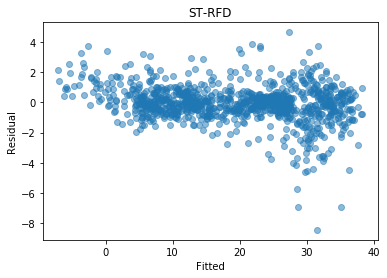

STConvS2S: 0.7221
Explained variance:  0.9822
r2:  0.9802
ar2:  0.9826


In [22]:
model, optimizer, epoch, loss = trainer.load_model()
batch_test_loss = 0.0
batch_explained_variance = 0.0
batch_r2 = 0.0
batch_ar2 = 0.0
model.eval()
y_true = None
with torch.no_grad():
    for i, (x, y) in enumerate(test_loader):
        x,y = x.to(device), y.to(device)
        states = trainer.init_hidden(x.size()[0], x.size()[3]*x.size()[4])
        output = model(x, states)
        loss = criterion(output, y)
        y_true = y.cpu().numpy()
        y_pred = output.cpu().numpy()
        if (i == 0):
            plot_residual_fitted(y_true[0,0,:,:], y_pred[0,0,:,:])
        batch_test_loss += loss.detach().item()
        batch_explained_variance += report_explained_variance(y_true, y_pred)
        r2, ar2 = report_r2(y_true, y_pred)
        batch_r2 += r2
        batch_ar2 += ar2
        
test_loss = batch_test_loss/len(test_loader)
explained_variance = batch_explained_variance/len(test_loader)
r2 = batch_r2/len(test_loader)
ar2 = batch_ar2/len(test_loader)
print(f'STConvS2S: {test_loss:.4f}')
print('Explained variance: ', round(explained_variance,4))
print('r2: ', round(r2,4))
print('ar2: ', round(ar2,4))